In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib as mpl
from scipy import interpolate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
os.environ["OMP_NUM_THREADS"] = '1'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'

In [2]:
water = pd.read_csv('C:/k_digital/source/data/data_city/data_tr_city.csv')

In [3]:
water['target'] = water['구미 혁신도시배수지 유출유량 적산차']
water = water.drop('구미 혁신도시배수지 유출유량 적산차', axis=1)

In [4]:
water['datetime'] = water['datetime'].astype('datetime64[ns]')

In [5]:
water = water.set_index('datetime')
water

,target
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0
...,...
2020-12-31 19:00:00,328.0
2020-12-31 20:00:00,347.0
2020-12-31 21:00:00,335.0


In [6]:
water.index = water.index.to_period('h')

In [7]:
water.index

PeriodIndex(['2017-01-01 01:00', '2017-01-01 02:00', '2017-01-01 03:00',
             '2017-01-01 04:00', '2017-01-01 05:00', '2017-01-01 06:00',
             '2017-01-01 07:00', '2017-01-01 08:00', '2017-01-01 09:00',
             '2017-01-01 10:00',
             ...
             '2020-12-31 14:00', '2020-12-31 15:00', '2020-12-31 16:00',
             '2020-12-31 17:00', '2020-12-31 18:00', '2020-12-31 19:00',
             '2020-12-31 20:00', '2020-12-31 21:00', '2020-12-31 22:00',
             '2020-12-31 23:00'],
            dtype='period[H]', name='datetime', length=35063)

<AxesSubplot:xlabel='datetime'>

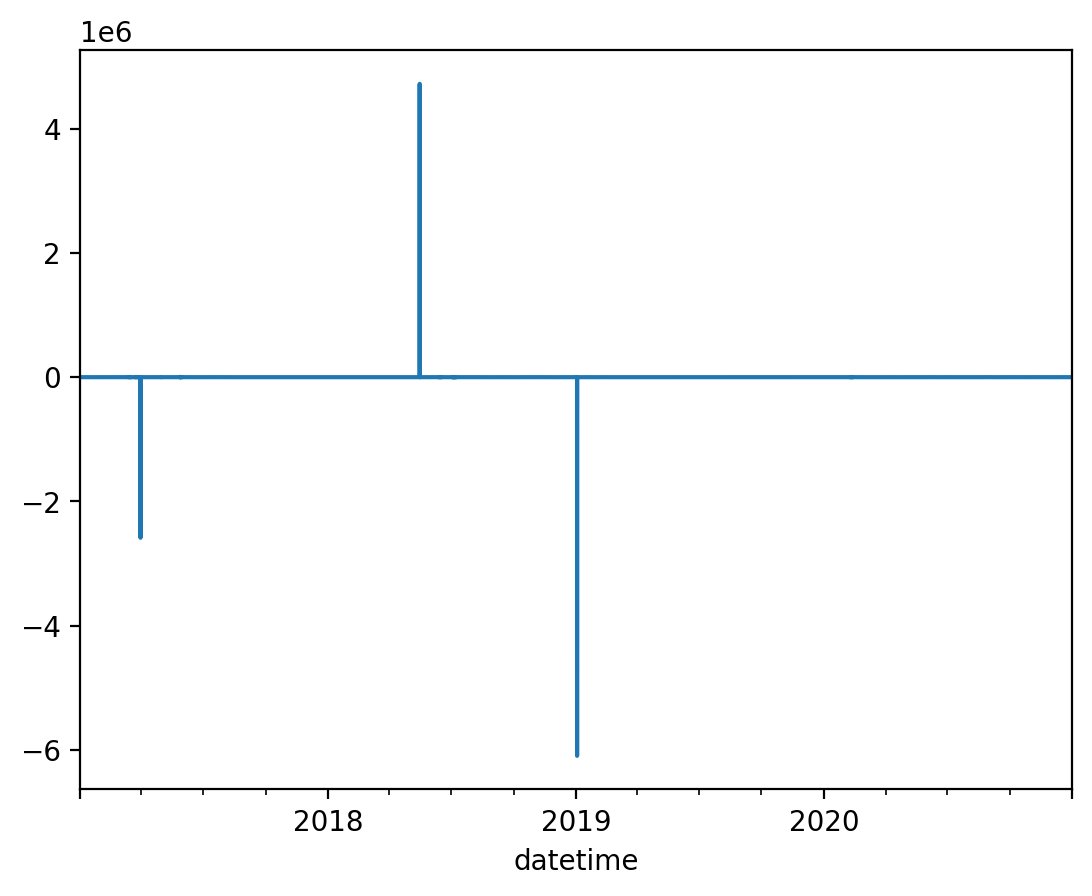

In [8]:
water.target.plot()

In [9]:
water.sort_values(by='target', ascending=False)

,target
datetime,
2018-05-15 20:00,4720655.0
2017-05-27 10:00,4999.0
2017-05-28 06:00,3357.0
2017-05-31 08:00,2591.0
2017-05-28 15:00,2550.0
...,...
2018-06-14 22:00,NaN
2018-07-04 12:00,NaN
2018-07-06 11:00,NaN


In [10]:
water.target = water.target.round(0)

In [11]:
water.target.replace(0, np.NaN, inplace=True)

<AxesSubplot:xlabel='datetime'>

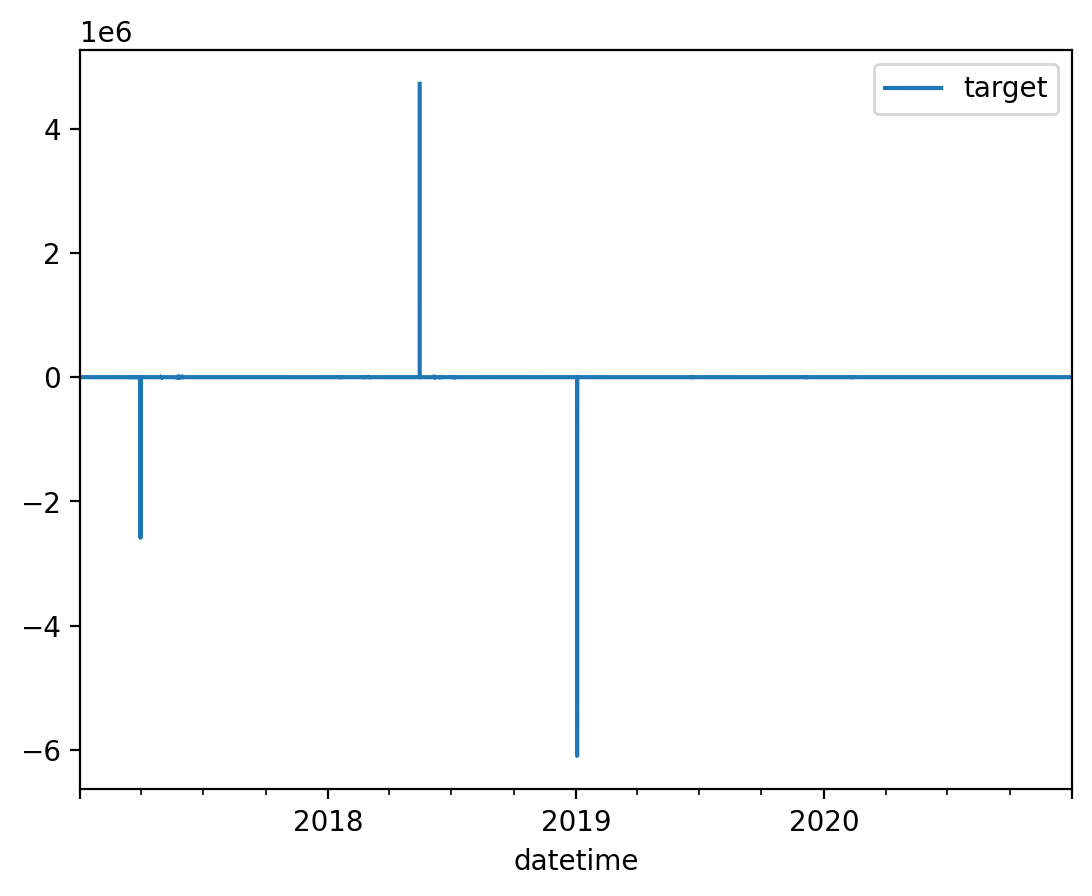

In [12]:
water.plot()

In [13]:
water[water.target == water.target.max()] = np.nan  # 위아래 평균값 넣기

In [14]:
for i in range(2):
    water[water.target == water.target.min()] = np.nan  # np.NaN

<AxesSubplot:xlabel='datetime'>

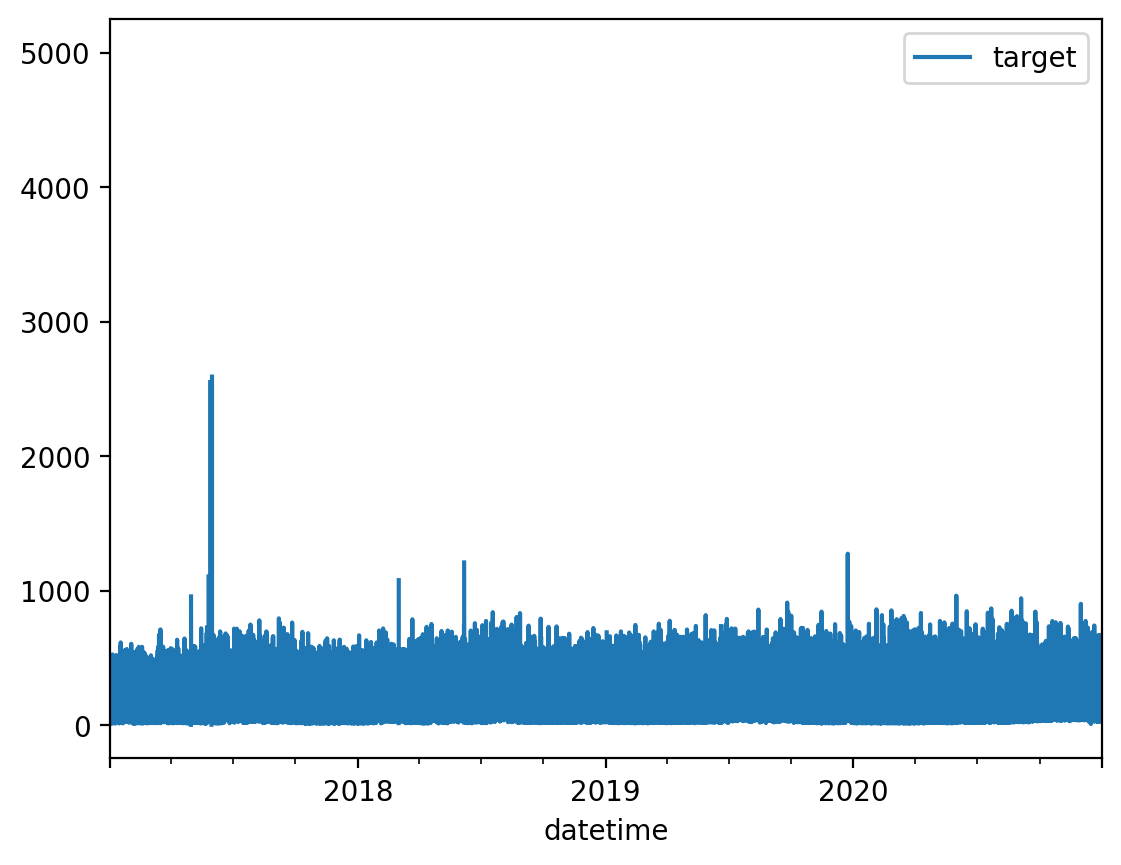

In [15]:
water.plot()

In [16]:
water[(water.index.year == 2017) & (water.index.month == 5) & (water.target.isna())]

,target
datetime,
2017-05-23 16:00,NaN
2017-05-23 18:00,NaN
2017-05-23 23:00,NaN
2017-05-24 21:00,NaN
2017-05-25 00:00,NaN
...,...
2017-05-31 03:00,NaN
2017-05-31 04:00,NaN
2017-05-31 05:00,NaN


### 5월 23, 24일 결측치처리 - 진행중

In [94]:
print(water[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24) & (water.index.hour >= 14)])

                  target
datetime                
2017-05-23 14:00  684.00
2017-05-23 15:00  104.00
2017-05-23 16:00  266.76
2017-05-23 17:00  404.82
2017-05-23 18:00  158.76
2017-05-23 19:00  366.00
2017-05-23 20:00   56.00
2017-05-23 21:00  234.00
2017-05-23 22:00  486.00
2017-05-23 23:00  519.40
2017-05-24 14:00  303.00
2017-05-24 15:00  366.00
2017-05-24 16:00  154.00
2017-05-24 17:00  129.00
2017-05-24 18:00  171.00
2017-05-24 19:00  344.00
2017-05-24 20:00  175.00
2017-05-24 21:00     NaN
2017-05-24 22:00  670.00
2017-05-24 23:00  151.00


In [24]:
print(water[(water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 15) & (water.index.hour <= 17)])

                  target
datetime                
2017-05-23 15:00  104.00
2017-05-23 16:00  266.76
2017-05-23 17:00  404.82
2018-05-23 15:00  227.00
2018-05-23 16:00  133.00
2018-05-23 17:00  402.00
2019-05-23 15:00   84.00
2019-05-23 16:00  228.00
2019-05-23 17:00  346.00
2020-05-23 15:00  456.00
2020-05-23 16:00  260.00
2020-05-23 17:00  147.00


In [19]:
filled = water.target[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 15) & (water.index.hour <= 17)].sum()
fill = water.target[(water.index.year == 2019) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 15) & (water.index.hour <= 17)].sum()

In [21]:
print((filled / fill).round(2))

1.17


In [22]:
water[water.index == '2017-05-23 16:00'] = water.target[water.index == '2019-05-23 16:00'] * 1.17
water[water.index == '2017-05-23 17:00'] = water.target[water.index == '2019-05-23 17:00'] * 1.17

In [76]:
print(water[(water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (water.index.hour >= 17) & (water.index.hour <= 19)])

                  target
datetime                
2017-05-23 17:00  404.82
2017-05-23 18:00  158.76
2017-05-23 19:00  366.00
2018-05-23 17:00  402.00
2018-05-23 18:00  179.00
2018-05-23 19:00  369.00
2019-05-23 17:00  346.00
2019-05-23 18:00  145.00
2019-05-23 19:00  319.00
2020-05-23 17:00  147.00
2020-05-23 18:00  293.00
2020-05-23 19:00  520.00


In [69]:
filled = water.target[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour > 17) & (water.index.hour < 19)].sum()
fill_1 = water.target[(water.index.year == 2018) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour > 17) & (water.index.hour < 19)].sum()
fill_2 = water.target[(water.index.year == 2019) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour > 17) & (water.index.hour < 19)].sum()

In [70]:
tot_fill = (fill_1+fill_2)/2
tot_fill = (filled/tot_fill).round(2)

In [229]:
(water.target[water.index == '2018-05-23 18:00'][0] + water.target[
    water.index == '2019-05-23 18:00'][0])/2

162.0

In [75]:
water[water.index == '2017-05-23 18:00'] = ((
    water.target[water.index == '2018-05-23 18:00'][0] + water.target[
        water.index == '2019-05-23 18:00'][0]) / 2) * 0.98

In [83]:
print(water[(water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (water.index.hour >= 22)])
print(water[(water.index.month == 5) & (
    water.index.day >= 24) & (water.index.day <= 24) & (water.index.hour <= 1)])

                  target
datetime                
2017-05-23 22:00   486.0
2017-05-23 23:00   519.4
2018-05-23 22:00   364.0
2018-05-23 23:00   490.0
2019-05-23 22:00   475.0
2019-05-23 23:00   459.0
2020-05-23 22:00   307.0
2020-05-23 23:00   132.0
                  target
datetime                
2017-05-24 00:00   249.1
2017-05-24 01:00   107.0
2018-05-24 00:00   235.0
2018-05-24 01:00   153.0
2019-05-24 00:00   390.0
2019-05-24 01:00   102.0
2020-05-24 00:00   198.0
2020-05-24 01:00   414.0


In [78]:
filled = (water.target[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 22)].sum() + water.target[
    (water.index.year == 2017) & (water.index.month == 5) & (
        water.index.day >= 24) & (water.index.day <= 24) & (
        water.index.hour <= 1)].sum())/2

In [79]:
fill = (water.target[(water.index.year == 2018) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 22)].sum() + water.target[
    (water.index.year == 2018) & (water.index.month == 5) & (
        water.index.day >= 24) & (water.index.day <= 24) & (
        water.index.hour <= 1)].sum())/2

In [81]:
tot_fill = ((filled / fill).round(2))

In [82]:
water[water.index == '2017-05-23 23:00'] = water.target[water.index == '2018-05-23 23:00'] * tot_fill
water[water.index == '2017-05-24 00:00'] = water.target[water.index == '2018-05-24 00:00'] * tot_fill

In [87]:
print(water[(water.index.month == 5) & (
    water.index.day >= 24) & (water.index.day < 25) & (water.index.hour >= 20) & (water.index.hour <= 22)])

                  target
datetime                
2017-05-24 20:00   175.0
2017-05-24 21:00     NaN
2017-05-24 22:00   670.0
2018-05-24 20:00   341.0
2018-05-24 21:00   313.0
2018-05-24 22:00   190.0
2019-05-24 20:00   459.0
2019-05-24 21:00   204.0
2019-05-24 22:00   332.0
2020-05-24 20:00   415.0
2020-05-24 21:00   357.0
2020-05-24 22:00   437.0


<AxesSubplot:xlabel='datetime'>

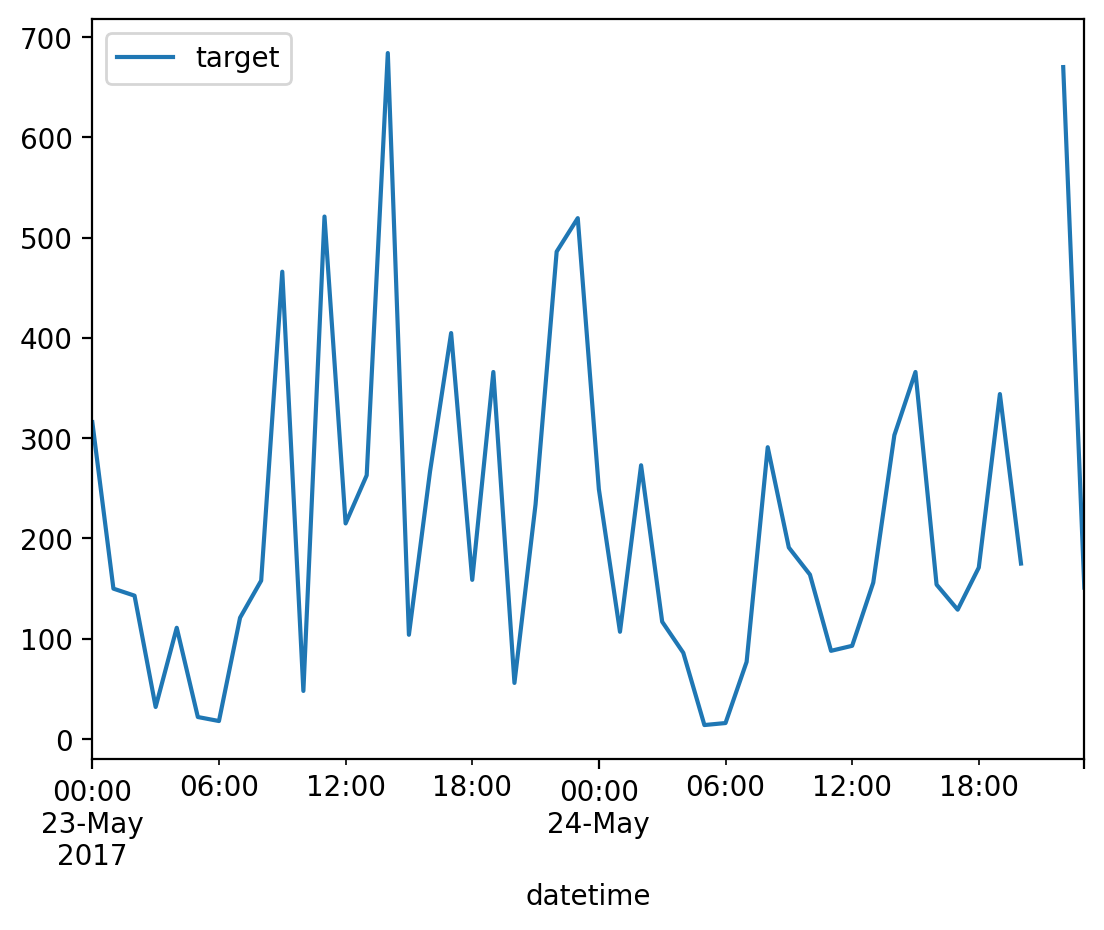

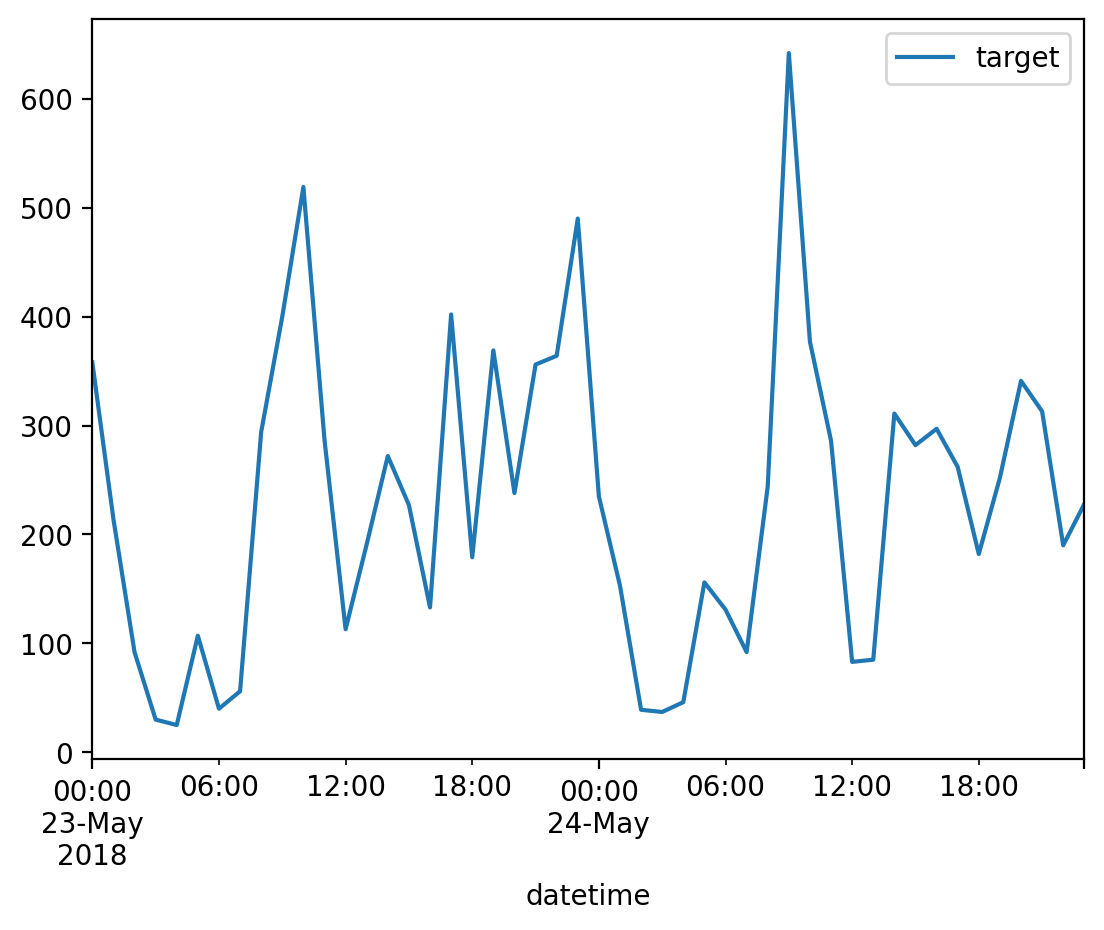

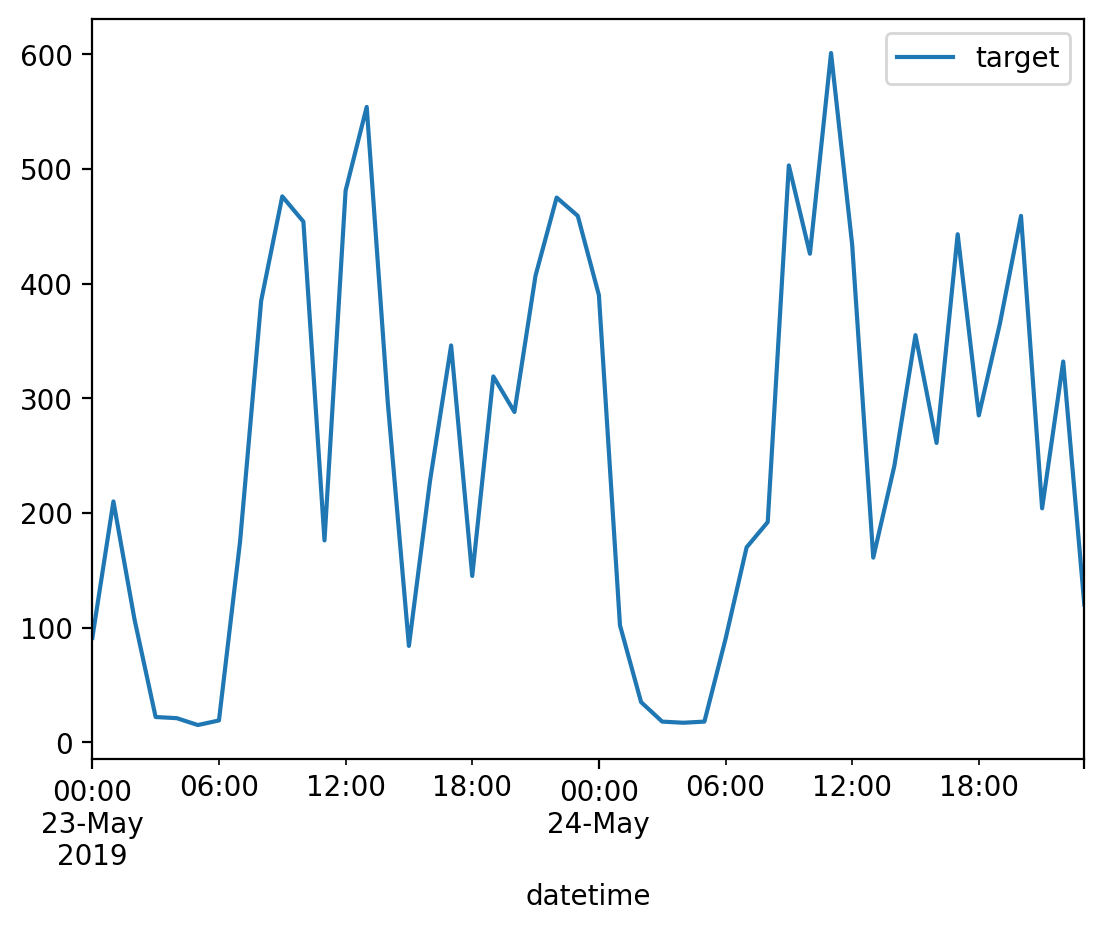

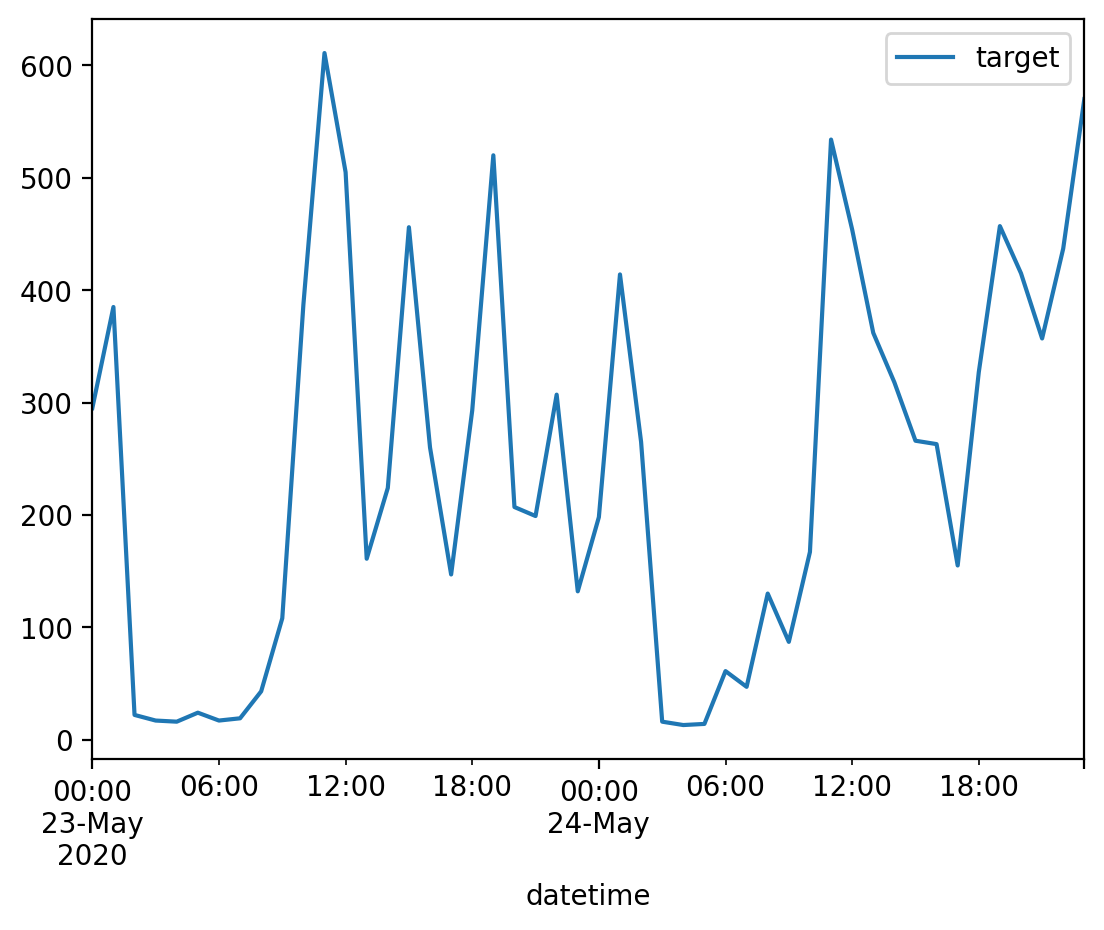

In [91]:
water[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()
water[(water.index.year == 2018) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()
water[(water.index.year == 2019) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()
water[(water.index.year == 2020) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()

In [96]:
water[(water.index.year == 2017) & (water.target.isna())]

,target
datetime,
2017-04-29 14:00,NaN
2017-04-29 16:00,NaN
2017-04-29 17:00,NaN
2017-04-29 18:00,NaN
2017-04-29 19:00,NaN
...,...
2017-05-31 03:00,NaN
2017-05-31 04:00,NaN
2017-05-31 05:00,NaN


In [97]:
water[(water.index.year == 2018) & (water.target.isna())]

,target
datetime,
2018-06-06 04:00,NaN
2018-06-06 05:00,NaN
2018-06-06 06:00,NaN
2018-06-06 07:00,NaN
2018-06-06 08:00,NaN
2018-06-06 12:00,NaN
2018-06-06 13:00,NaN
2018-06-06 14:00,NaN
2018-06-06 15:00,NaN


In [98]:
water[(water.index.year == 2019) & (water.target.isna())]

,target
datetime,


In [99]:
water[(water.index.year == 2020) & (water.target.isna())]

,target
datetime,


In [47]:
water.target.isna().sum()

132

In [162]:
def view_time(month, day, hour):
    print(water[(water.index.month == month) & (water.index.day == day) & (
        water.index.hour >= hour-1) & (water.index.hour <= hour+1)])

In [163]:
view_time(6, 18, 20)

                  target
datetime                
2017-06-18 19:00   580.0
2017-06-18 20:00   222.0
2017-06-18 21:00   113.0
2018-06-18 19:00   459.0
2018-06-18 20:00   306.0
2018-06-18 21:00   330.0
2019-06-18 19:00   406.0
2019-06-18 20:00    87.0
2019-06-18 21:00   142.0
2020-06-18 19:00   146.0
2020-06-18 20:00   535.0
2020-06-18 21:00   535.0


In [244]:
# 0이 한개 또는 여러개 조건문
def replaced(x, month, day, hour, *args):
    if x == 0:
        if len(args) == 2:
            a, b = args
            filled = water.target[(water.index.year == a) & (water.index.month == month) & (water.index.day >= day-1) & (
                water.index.day < day+1) & (water.index.hour >= hour-1) & (water.index.hour <= hour+1)].sum()
            fill = water.target[(water.index.year == b) & (water.index.month == month) & (water.index.day >= day-1) & (
                water.index.day < day+1) & (water.index.hour >= hour-1) & (water.index.hour <= hour+1)].sum()
            a_result = '{}-{}-{} {}:00'.format(a, month, day, hour)
            b_result = '{}-{}-{} {}:00'.format(b, month, day, hour)
            tot_fill = ((filled / fill).round(2))
            water[water.index == a_result] = (water.target[water.index == b_result] * tot_fill).round(2)
            print('a')
        elif len(args) == 3:
            a, b, c = args
            filled = water.target[(water.index.year == a) & (water.index.month == month) & (water.index.day >= day-1) & (
                water.index.day < day+1) & (water.index.hour > hour-1) & (water.index.hour < hour+1)].sum()
            fill_1 = water.target[(water.index.year == b) & (water.index.month == month) & (water.index.day >= day-1) & (
                water.index.day < day+1) & (water.index.hour > hour-1) & (water.index.hour < hour+1)].sum()
            fill_2 = water.target[(water.index.year == c) & (water.index.month == month) & (water.index.day >= day-1) & (
                water.index.day < day+1) & (water.index.hour > hour-1) & (water.index.hour < hour+1)].sum()
            a_result = '{}-{}-{} {}:00'.format(a, month, day, hour)
            b_result = '{}-{}-{} {}:00'.format(b, month, day, hour)
            c_result = '{}-{}-{} {}:00'.format(c, month, day, hour)
            tot_fill = (fill_1+fill_2)/2
            tot_fill = (filled/tot_fill).round(2)
            water[water.index == a_result] = (((water.target[water.index == b_result][0] + water.target[
                water.index ==  c_result][0]) / 2) * tot_fill).round(2)
            print('b')
        else:
            a, b, c, d = args
            filled = water.target[(water.index.year == a) & (water.index.month == month) & (water.index.day >= day-1) & (
                water.index.day < day+1) & (water.index.hour > hour-1) & (water.index.hour < hour+1)].sum()
            fill_1 = water.target[(water.index.year == b) & (water.index.month == month) & (water.index.day >= day-1) & (
                water.index.day < day+1) & (water.index.hour > hour-1) & (water.index.hour < hour+1)].sum()
            fill_2 = water.target[(water.index.year == c) & (water.index.month == month) & (water.index.day >= day-1) & (
                water.index.day < day+1) & (water.index.hour > hour-1) & (water.index.hour < hour+1)].sum()
            fill_3 = water.target[(water.index.year == d) & (water.index.month == month) & (water.index.day >= day-1) & (
                water.index.day < day+1) & (water.index.hour > hour-1) & (water.index.hour < hour+1)].sum()
            a_result = '{}-{}-{} {}:00'.format(a, month, day, hour)
            b_result = '{}-{}-{} {}:00'.format(b, month, day, hour)
            c_result = '{}-{}-{} {}:00'.format(c, month, day, hour)
            d_result = '{}-{}-{} {}:00'.format(d, month, day, hour)
            tot_fill = (fill_1+fill_2+fill_3)/3
            tot_fill = (filled/tot_fill).round(2)
            water[water.index == a_result] = (((water.target[water.index == b_result][0] + water.target[
                water.index ==  c_result][0] + (water.target[water.index == d_result][0]) / 3)) * tot_fill).round(2)
            print('c')
    else:
        a = args
        i = 1
        count = 0
        fill_tot = 0
        filled_tot = 0
        find = water[water.index == '{}-{}-{} {}:00'.format(a, month, day, hour)]  # 입력값
        while True:
            if water.target[find.index - i][0] != 0:
                break
            else:
                count += 1
                i += 1
        # (count 갯수만큼 다른 년도)의 같은 시간대 불러오기(월, 일 동일)
        for i in water.index.year.unique().difference([a]):
            for j in range(1, count+1):
                (water[(water.index.year == i) & (water.index.month == month) & (
                    water.index.day == day) & (water.index.hour == hour)].index-j)[0]
        # 불러온뒤 평균 구하기
                fill_tot += water[water.index == (water.target[(water.index.year == i) & (water.index.month == month) & (
                    water.index.day == day) & (water.index.hour == hour)].index-j)[0]].target[0]
        fill = (fill_tot/3).round(2)
        # 원하는 년도와 다른 년도의 평균의 비율을 구함
        for j in range(1, count+1):
            filled_tot += water[water.index == (water.target[(water.index.year == a) & (water.index.month == month) & (
                    water.index.day == day) & (water.index.hour == hour)].index-j)[0]].target[0]
        rate = filled_tot / fill
        rate = rate.round(2)
        # 각 행의 평균에 비율을 곱해서 결측치 채우기
        water[water.index == (water.target[(water.index.year == i) & (water.index.month == month) & (
                    water.index.day == day) & (water.index.hour == hour)].index-j)[0]].target[0]

In [481]:
replaced(1, 5, 15, 8, 2017)